<a href="https://colab.research.google.com/github/tanvir-talha058/Machine-Learning/blob/main/banglabert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers datasets pandas scikit-learn


In [2]:
pip install -U transformers


In [3]:
pip install --upgrade transformers


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding, set_seed
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Set random seed
set_seed(42)

# Step 1: Load CSV
df = pd.read_csv("dataset.csv")  # Save your Excel as CSV first

# Step 2: Reshape Data
rows = []
for col in df.columns:
    for val in df[col].dropna():
        rows.append({'text': val.strip(), 'label': col})

data = pd.DataFrame(rows)

# Step 3: Label Encoding
label2id = {label: i for i, label in enumerate(data['label'].unique())}
id2label = {i: label for label, i in label2id.items()}
data['label_id'] = data['label'].map(label2id)

# Step 4: Train-test split
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label_id'], random_state=42)

# Step 5: Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label_id']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label_id']]) # Corrected syntax

# Step 6: Load BanglaBERT Tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename 'label_id' to 'labels' in the datasets BEFORE initializing Trainer
train_dataset = train_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")


# Step 7: Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

# Step 8: Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

# Step 9: Training Config
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    save_strategy="epoch",
    # label_column_name="labels" # Removed this as it's not a valid argument
)

# Step 10: Train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


# Add a print statement to inspect the dataset keys before training
print("Train dataset features:", train_dataset.features)
print("Test dataset features:", test_dataset.features)


trainer.train()

# Optional: Save Model
model.save_pretrained("banglabert-dialect-classifier2")
tokenizer.save_pretrained("banglabert-dialect-classifier2")

Map:   0%|          | 0/1412 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2550608716.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Train dataset features: {'text': Value('string'), 'labels': Value('int64'), '__index_level_0__': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}
Test dataset features: {'text': Value('string'), 'labels': Value('int64'), '__index_level_0__': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.638923,0.201133,0.066981
2,No log,1.618650,0.198300,0.071204


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


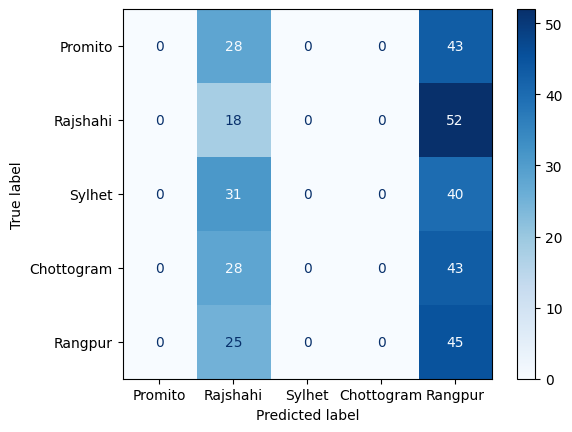

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Import numpy

y_true = trainer.eval_dataset["labels"] # Changed from "label_id" to "labels"
y_pred = np.argmax(trainer.predict(trainer.eval_dataset).predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2id.keys())
disp.plot(cmap="Blues")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


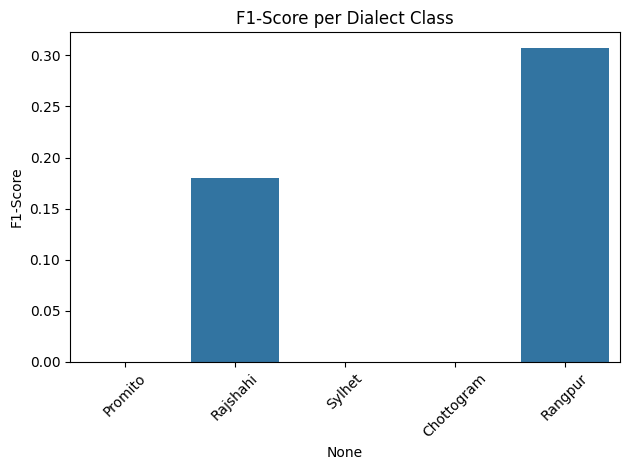

In [8]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true, y_pred, target_names=label2id.keys(), output_dict=True)
df_report = pd.DataFrame(report).transpose()

sns.barplot(x=df_report.index[:-3], y=df_report["f1-score"][:-3])
plt.title("F1-Score per Dialect Class")
plt.ylabel("F1-Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


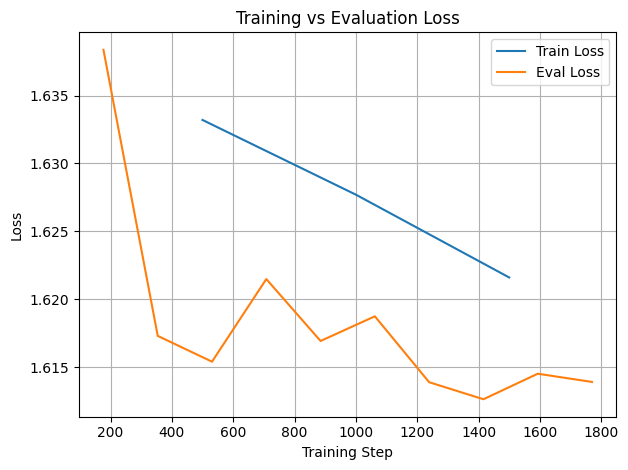

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

train_loss = df_logs[df_logs["loss"].notnull()][["step", "loss"]]
eval_loss = df_logs[df_logs["eval_loss"].notnull()][["step", "eval_loss"]]

plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
